# Управление рисками и принятие решений о покупке для молочного хозяйства "Вольный луг"

## Описание проекта

К вам обратился фермер, владелец молочного хозяйства «Вольный луг». Он хочет купить бурёнок, чтобы расширить поголовье стада коров. Для этого он заключил выгодный контракт с ассоциацией пастбищ «ЭкоФерма».
Условия позволяют фермеру очень тщательно отобрать коров. Он определяет качество молока по строгой методике, и при этом ему нужно выполнять свой план развития молочного хозяйства. Фермер хочет, чтобы каждая бурёнка давала не менее 6000 килограммов молока в год, а её надой был вкусным — строго по его критериям, ничуть не хуже. А продавцы и технологи так и норовят приукрасить своих коровок!

Поэтому он просит вас разработать модель машинного обучения, которая поможет ему управлять рисками и принимать объективное решение о покупке. «ЭкоФерма» готова предоставить подробные данные о своих коровах. Вам нужно создать две прогнозные модели для отбора бурёнок в поголовье:
1. Первая будет прогнозировать возможный удой коровы (целевой признак `Удой`)
2. Вторая — рассчитывать вероятность получить вкусное молоко от коровы (целевой признак `Вкус молока`)

**С помощью модели нужно отобрать коров по двум критериям:**
* Средний удой за год — не менее 6000 килограммов
* Молоко должно быть вкусным

## Описание данных

Файл `ferma_main.csv` содержит данные о стаде фермера на текущий момент. Описание данных:
* id — уникальный идентификатор коровы.
* Удой, кг — масса молока, которую корова даёт в год (в килограммах).
* ЭКЕ (Энергетическая кормовая единица) — показатель питательности корма коровы.
* Сырой протеин, г — содержание сырого протеина в корме (в граммах).
* СПО (Сахаро-протеиновое соотношение) — отношение сахара к протеину в корме коровы.
* Порода — порода коровы.
* Тип пастбища — ландшафт лугов, на которых паслась корова.
* порода папы_быка — порода папы коровы.
* Жирность,% — содержание жиров в молоке (в процентах).
* Белок,% — содержание белков в молоке (в процентах).
* Вкус молока — оценка вкуса по личным критериям фермера, бинарный признак (вкусно, не вкусно).
* Возраст — возраст коровы, бинарный признак (менее_2_лет, более_2_лет).

Признаки в датасете `ferma_main.csv` можно разделить на группы.
* **Характеристики коровы:** id, Порода, порода папы_быка, Возраст.
* **Характеристики корма:** ЭКЕ (Энергетическая кормовая единица), Сырой протеин, г, СПО (Сахаро-протеиновое соотношение).
* **Характеристика пастбища:** Тип пастбища.
* **Характеристики молока:** Удой, кг, Жирность,%, Белок,%, Вкус молока.

Файл `ferma_dad.csv` хранит имя папы каждой коровы в стаде фермера. Описание данных:
* id — уникальный идентификатор коровы.
* Имя Папы — имя папы коровы.

Файл `cow_buy.csv` — это данные о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой. Описание данных:
* Порода — порода коровы.
* Тип пастбища — ландшафт лугов, на которых паслась корова.
* порода папы_быка — порода папы коровы.
* Имя_папы — имя папы коровы.
* Текущая_жирность,% — содержание жиров в молоке (в процентах).
* Текущий_уровень_белок,% — содержание белков в молоке (в процентах).
* Возраст — возраст коровы, бинарный признак (менее_2_лет, более_2_лет).

Данные в файлах `ferma_main.csv` и `cow_buy.csv` похожи, но у датасета `cow_buy.csv` несколько особенностей:
1. Содержание белков и жиров в молоке указано на момент продажи — когда «ЭкоФерма» давала коровам свой корм.
2. Параметры корма ЭКЕ (Энергетическая кормовая единица), Сырой протеин и СПО (Сахаро-протеиновое соотношение) отсутствуют. Технологи заказчика пересмотрели подход к кормлению: для новых коров планируется увеличить значения каждого из этих параметров на 5%.
3. Кроме того, отсутствуют признаки Удой, кг и Вкус молока. Это целевые признаки, именно их предстоит предсказать!

## Загрузка и общая информация о данных

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
from scipy.stats import spearmanr
import numpy as np
import seaborn as sns
import phik
from pylab import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    r2_score, mean_squared_error, root_mean_squared_error, 
    mean_absolute_error, accuracy_score, confusion_matrix, 
    recall_score, precision_score, precision_recall_curve)

In [15]:
# Загружаем данные
try:
    df_main = pd.read_csv('/datasets/ferma_main.csv', sep = ';', decimal=',')
    df_dad = pd.read_csv('/datasets/ferma_dad.csv', sep = ';', decimal=',')
    df_buy = pd.read_csv('/datasets/cow_buy.csv', sep = ';', decimal=',')
except:
    df_main = pd.read_csv('ferma_main.csv', sep = ';', decimal=',')
    df_dad = pd.read_csv('ferma_dad.csv', sep = ';', decimal=',')
    df_buy = pd.read_csv('cow_buy.csv', sep = ';', decimal=',')

In [17]:
def information(dataset):
    display(dataset.head())
    display(dataset.tail())
    print(dataset.info())
    print('Количество пропусков:\n', dataset.isna().sum())
    print('Количество явных дубликатов:', dataset.duplicated().sum())
    display(dataset.describe().T)

In [18]:
# Посмотрим датасет с общими данными 
information(df_main)

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
629,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
630,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
631,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
632,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
633,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   Удой, кг                               634 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 3   Сырой протеин, г                       634 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 5   Порода                                 634 non-null    object 
 6   Тип пастбища                           634 non-null    object 
 7   порода папы_быка                       634 non-null    object 
 8   Жирность,%                             634 non-null    float64
 9   Белок,%                                634 non-null    float64
 10  Вкус молока                            634 non-null    object 
 11  Возрас

,count,mean,std,min,25%,50%,75%,max
id,634.0,317.460568,183.096982,1.000,159.250,317.500,475.750,629.000
"Удой, кг",634.0,6187.025237,1638.401021,5204.000,5751.750,6130.500,6501.000,45616.000
ЭКЕ (Энергетическая кормовая единица),634.0,14.542744,1.301301,10.900,13.500,14.700,15.600,16.800
"Сырой протеин, г",634.0,1922.682965,182.392548,1660.000,1772.250,1880.500,2058.750,2349.000
СПО (Сахаро-протеиновое соотношение),634.0,0.912855,0.032209,0.840,0.890,0.930,0.940,0.960
"Жирность,%",634.0,3.603943,0.168020,2.990,3.590,3.650,3.720,3.750
"Белок,%",634.0,3.075666,0.002540,3.069,3.074,3.076,3.077,3.085


**При изучении общей информации о данных `df_main`можно выделить важные моменты:**
* Пропущенные значения отсутствуют
* Есть 5 дубликатов, которые нужно убрать
* Тип данных не соответствует для столбцов: `ЭКЕ (Энергетическая кормовая единица)`, `СПО (Сахаро-протеиновое соотношение)`, `Жирность,%`, `Белок,%`
* Нужно привести названия столбцов к общему виду

In [21]:
# Посмотрим датасет с папами коров
information(df_dad)

,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


,id,Имя Папы
624,625,Буйный
625,626,Барин
626,627,Барин
627,628,Барин
628,629,Соловчик


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB
None
Количество пропусков:
 id          0
Имя Папы    0
dtype: int64
Количество явных дубликатов: 0


,count,mean,std,min,25%,50%,75%,max
id,629.0,315.0,181.72094,1.0,158.0,315.0,472.0,629.0


**При изучении общей информации о данных `df_dad`можно выделить важные моменты:**
* Данные в порядке
* Необходимо привести название столбцов к общему виду

In [23]:
# Посмотрим датасет покупки
information(df_buy)

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
15,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.065,более_2_лет
16,Вис Бик Айдиал,холмистое,Соверин,Соловчик,3.73,3.079,более_2_лет
17,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.77,3.053,менее_2_лет
18,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.34,3.069,более_2_лет
19,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Порода                   20 non-null     object 
 1   Тип пастбища             20 non-null     object 
 2   порода папы_быка         20 non-null     object 
 3   Имя_папы                 20 non-null     object 
 4   Текущая_жирность,%       20 non-null     float64
 5   Текущий_уровень_белок,%  20 non-null     float64
 6   Возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB
None
Количество пропусков:
 Порода                     0
Тип пастбища               0
порода папы_быка           0
Имя_папы                   0
Текущая_жирность,%         0
Текущий_уровень_белок,%    0
Возраст                    0
dtype: int64
Количество явных дубликатов: 4


,count,mean,std,min,25%,50%,75%,max
"Текущая_жирность,%",20.0,3.5775,0.126818,3.340,3.510,3.590,3.650,3.770
"Текущий_уровень_белок,%",20.0,3.0695,0.010339,3.046,3.064,3.074,3.076,3.081


**При изучении общей информации о данных `df_buy`можно выделить важные моменты:**
* Пропущенные значения отсутствуют
* Есть 4 дубликата
* Тип данных не соответствует для столбцов: `Текущая_жирность,%`, `Текущий_уровень_белок,%`
* Нужно привести названия столбцов к общему виду

## Подготовка данных

**Предобработка для `df_main`**

In [27]:
df_main.columns

Index(['id', 'Удой, кг', 'ЭКЕ (Энергетическая кормовая единица)',
       'Сырой протеин, г', 'СПО (Сахаро-протеиновое соотношение)', 'Порода',
       'Тип пастбища', 'порода папы_быка', 'Жирность,%', 'Белок,%',
       'Вкус молока', 'Возраст'],
      dtype='object')

In [28]:
# Приведем названия столбцов к общему виду
df_main = df_main.rename(columns = {
    'Удой, кг':'удой',
    'ЭКЕ (Энергетическая кормовая единица)': 'эке',
    'Сырой протеин, г':'сырой_протеин',
    'СПО (Сахаро-протеиновое соотношение)':'спо',
    'Тип пастбища':'тип_пастбища',
    'порода папы_быка':'порода_папы_быка',
    'Жирность,%':'жирность',
    'Белок,%':'белок',
    'Вкус молока':'вкус_молока'})
df_main.columns = df_main.columns.str.lower()

In [30]:
df_main.columns

Index(['id', 'удой', 'эке', 'сырой_протеин', 'спо', 'порода', 'тип_пастбища',
       'порода_папы_быка', 'жирность', 'белок', 'вкус_молока', 'возраст'],
      dtype='object')

In [31]:
# Избавимся от явных дубликатов
df_main = df_main.drop_duplicates().reset_index(drop = True)
df_main.duplicated().sum()

0

In [33]:
df_main

,id,удой,эке,сырой_протеин,спо,порода,тип_пастбища,порода_папы_быка,жирность,белок,вкус_молока,возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет
...,...,...,...,...,...,...,...,...,...,...,...,...
624,625,6812,15.4,1964,0.940,РефлешнСоверинг,Равнинное,Айдиал,3.74,3.075,не вкусно,более_2_лет
625,626,5513,12.9,1700,0.880,РефлешнСоверинг,Равнинное,Соверин,3.64,3.073,вкусно,менее_2_лет
626,627,5970,14.4,1837,0.880,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
627,628,5746,13.8,1994,0.890,РефлешнСоверинг,Равнинное,Соверин,3.64,3.077,вкусно,более_2_лет


In [34]:
# Посмотрим неявные дубликаты
columns = ['порода', 'тип_пастбища', 'порода_папы_быка', 'вкус_молока', 'возраст']
for column in df_main[columns]:
    print(column, df_main[column].unique())

порода ['Вис Бик Айдиал' 'РефлешнСоверинг']
тип_пастбища ['Равнинное' 'Равнинные' 'Холмистое']
порода_папы_быка ['Айдиал' 'Соверин' 'Айдиалл']
вкус_молока ['вкусно' 'не вкусно']
возраст ['более_2_лет' 'менее_2_лет']


**В столбцах, где требуются числовые данных, все в порядке. \
Столбец `тип_пастбища` имеет дубликат `Равнинное`, `Равнинные`\
Столбец `порода_папы_быка` имеет дубликат `Айдиал`, `Айдиалл`**

In [37]:
# Избавляемся от неявных дубликатов 
df_main['тип_пастбища'] = df_main['тип_пастбища'].replace('Равнинные', 'Равнинное')
print(df_main['тип_пастбища'].unique())
df_main['порода_папы_быка'] = df_main['порода_папы_быка'].replace('Айдиалл', 'Айдиал')
print(df_main['порода_папы_быка'].unique())

['Равнинное' 'Холмистое']
['Айдиал' 'Соверин']


In [38]:
# Посмотрим на типы данных
df_main.dtypes

id                    int64
удой                  int64
эке                 float64
сырой_протеин         int64
спо                 float64
порода               object
тип_пастбища         object
порода_папы_быка     object
жирность            float64
белок               float64
вкус_молока          object
возраст              object
dtype: object

In [39]:
# Поменяем типы данных на нужный
for column in df_main[['эке','спо','жирность','белок']]:
    df_main[column] = df_main[column].astype('float32')

In [40]:
df_main.dtypes

id                    int64
удой                  int64
эке                 float32
сырой_протеин         int64
спо                 float32
порода               object
тип_пастбища         object
порода_папы_быка     object
жирность            float32
белок               float32
вкус_молока          object
возраст              object
dtype: object

**Предобработка для `df_dad`**

In [42]:
df_dad.columns

Index(['id', 'Имя Папы'], dtype='object')

In [43]:
# Приведем названия столбцов к общему виду
df_dad = df_dad.rename(columns = {'Имя Папы':'имя_папы'})
df_dad.columns

Index(['id', 'имя_папы'], dtype='object')

In [44]:
# Проверка на неявные дубликаты
df_dad['имя_папы'].unique()

array(['Буйный', 'Соловчик', 'Барин', 'Геркулес'], dtype=object)

**Предобработка для `df_buy`**

In [46]:
df_buy.columns

Index(['Порода', 'Тип пастбища', 'порода папы_быка', 'Имя_папы',
       'Текущая_жирность,%', 'Текущий_уровень_белок,%', 'Возраст'],
      dtype='object')

In [47]:
# Приведем названия столбцов к общему виду
df_buy = df_buy.rename(columns = {
    'Тип пастбища':'тип_пастбища', 
    'порода папы_быка' : 'порода_папы_быка',
    'Текущая_жирность,%':'жирность', 
    'Текущий_уровень_белок,%':'белок'})
df_buy.columns = df_buy.columns.str.lower()
df_buy.columns

Index(['порода', 'тип_пастбища', 'порода_папы_быка', 'имя_папы', 'жирность',
       'белок', 'возраст'],
      dtype='object')

In [48]:
# Посмотрим неявные дубликаты
for column in df_buy.columns:
    print(column, df_buy[column].unique())

порода ['Вис Бик Айдиал' 'РефлешнСоверинг']
тип_пастбища ['холмистое' 'равнинное']
порода_папы_быка ['Айдиал' 'Соверин']
имя_папы ['Геркулес' 'Буйный' 'Барин' 'Соловчик']
жирность [3.58 3.54 3.59 3.4  3.64 3.63 3.57 3.73 3.68 3.42 3.77 3.34]
белок [3.076 3.081 3.074 3.061 3.053 3.079 3.055 3.073 3.046 3.075 3.065 3.069]
возраст ['более_2_лет' 'менее_2_лет']


In [49]:
# Поменяем тип_пастбища на такой же, как в df_main 
df_buy['тип_пастбища'] = df_buy['тип_пастбища'].replace({'холмистое':'Холмистое', 'равнинное':'Равнинное'})
df_buy['тип_пастбища'].unique()

array(['Холмистое', 'Равнинное'], dtype=object)

### Вывод по предобработке данных
* Привели названия столбцов к общему виду
* Избавились от явных и неявных дубликатов
* Изменили тип даннхы на подходящий
* Проверили наличие пропущенных значений

## Исследовательский анализ

In [53]:
df_main.head()

,id,удой,эке,сырой_протеин,спо,порода,тип_пастбища,порода_папы_быка,жирность,белок,вкус_молока,возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет


In [54]:
df_main.describe().T

,count,mean,std,min,25%,50%,75%,max
id,629.0,315.000000,181.720940,1.000,158.000,315.000,472.000,629.000000
удой,629.0,6188.750397,1644.795489,5204.000,5751.000,6133.000,6501.000,45616.000000
эке,629.0,14.543879,1.306409,10.900,13.500,14.700,15.600,16.799999
сырой_протеин,629.0,1923.364070,182.956251,1660.000,1771.000,1888.000,2062.000,2349.000000
спо,629.0,0.913116,0.032203,0.840,0.890,0.930,0.940,0.960000
жирность,629.0,3.603657,0.168656,2.990,3.590,3.650,3.720,3.750000
белок,629.0,3.075671,0.002549,3.069,3.074,3.076,3.077,3.085000


### Анализ количественных признаков

In [56]:
# Функция для отрисовки гистограммы и ящика с усами
def box_hist_plot(df, column, title):

    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    sns.histplot(data=df[column], bins=20, ax=axes[0], color = 'skyblue')
    axes[0].set(ylabel='Количество коров', xlabel=column)

    sns.boxplot(data=df[column], ax=axes[1], color = 'darkseagreen')
    axes[1].set(ylabel=column)

    plt.suptitle(title)
    plt.show()

### Удой

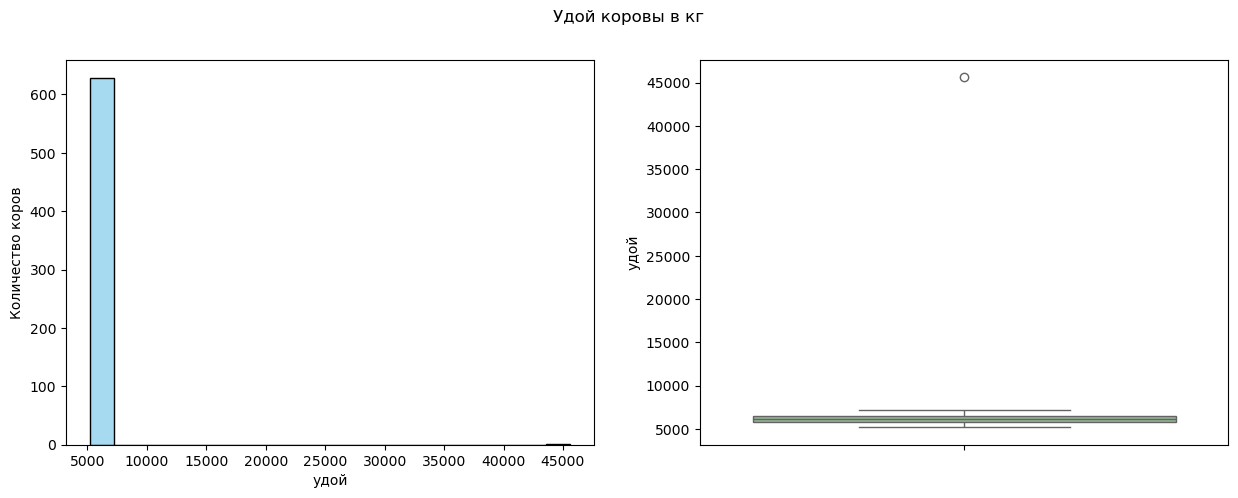

In [58]:
box_hist_plot(df_main, 'удой', 'Удой коровы в кг')

In [59]:
df_main['удой'].sort_values(ascending = False).head()

16     45616
70      7222
135     7207
296     7201
294     7197
Name: удой, dtype: int64

In [60]:
df_main = df_main.query('удой != 45616')

**Изучив подробнее значение `удой` = 45616, делаем вывод, что это выброс, поэтому от него можно избавиться**

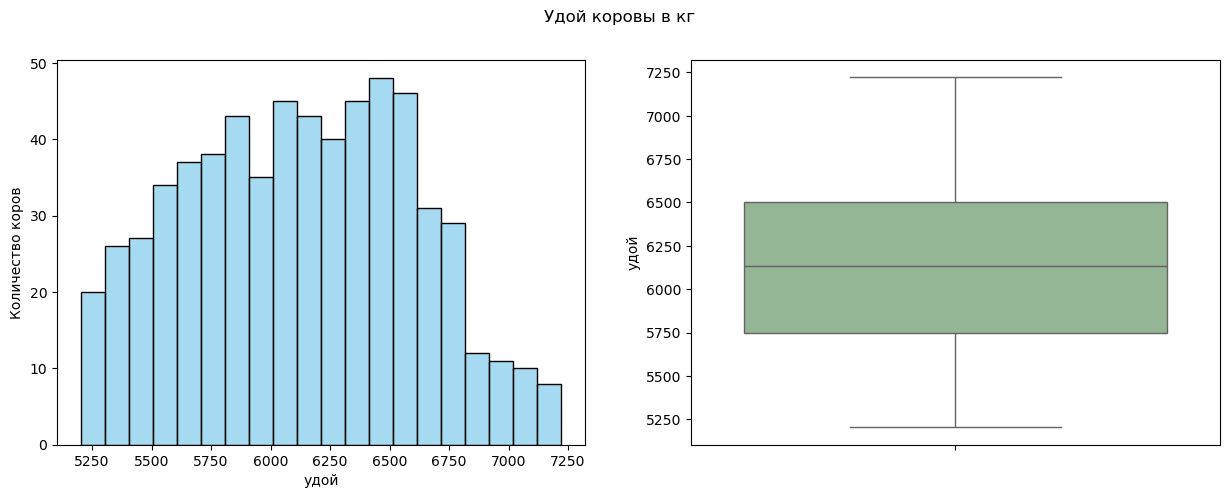

In [63]:
box_hist_plot(df_main, 'удой', 'Удой коровы в кг')

**После удаления выброса распределение похоже на нормальное**

### Эке

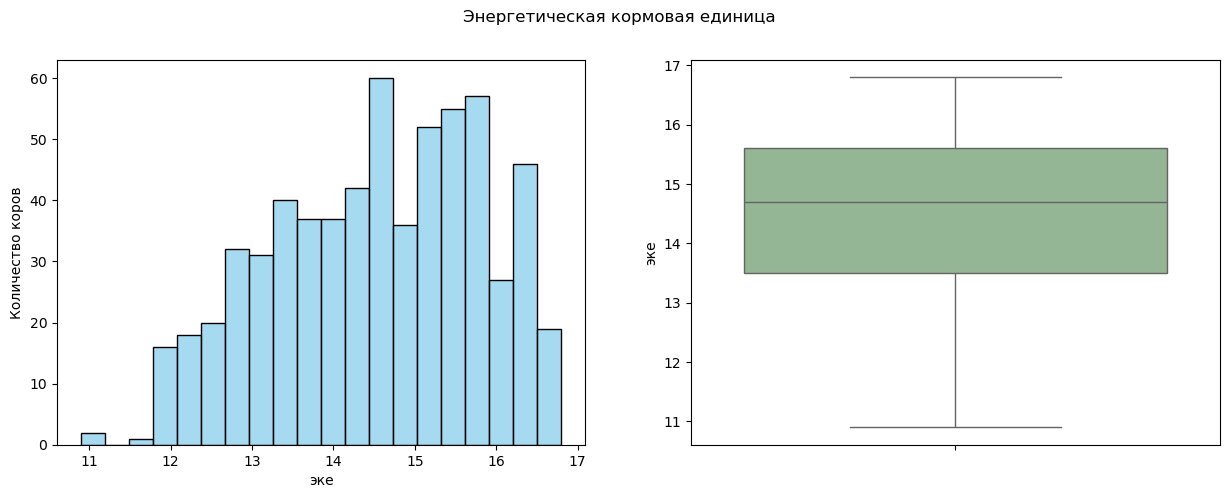

In [67]:
box_hist_plot(df_main, 'эке', 'Энергетическая кормовая единица')

### Сырой протеин

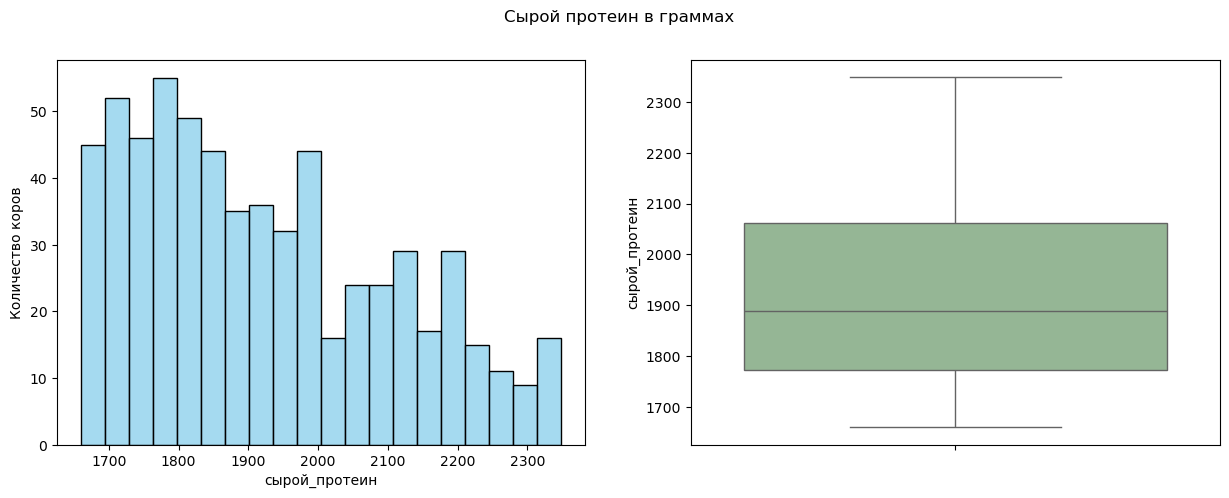

In [69]:
box_hist_plot(df_main, 'сырой_протеин', 'Сырой протеин в граммах')

### Сахарно-протеиновое соотношение

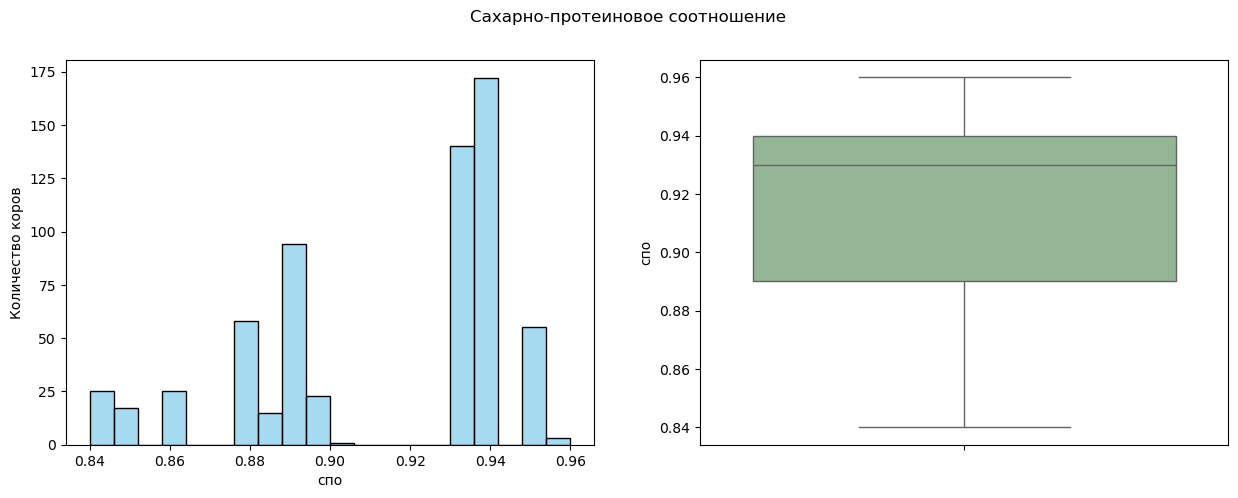

In [71]:
box_hist_plot(df_main, 'спо', 'Сахарно-протеиновое соотношение')

### Жирность

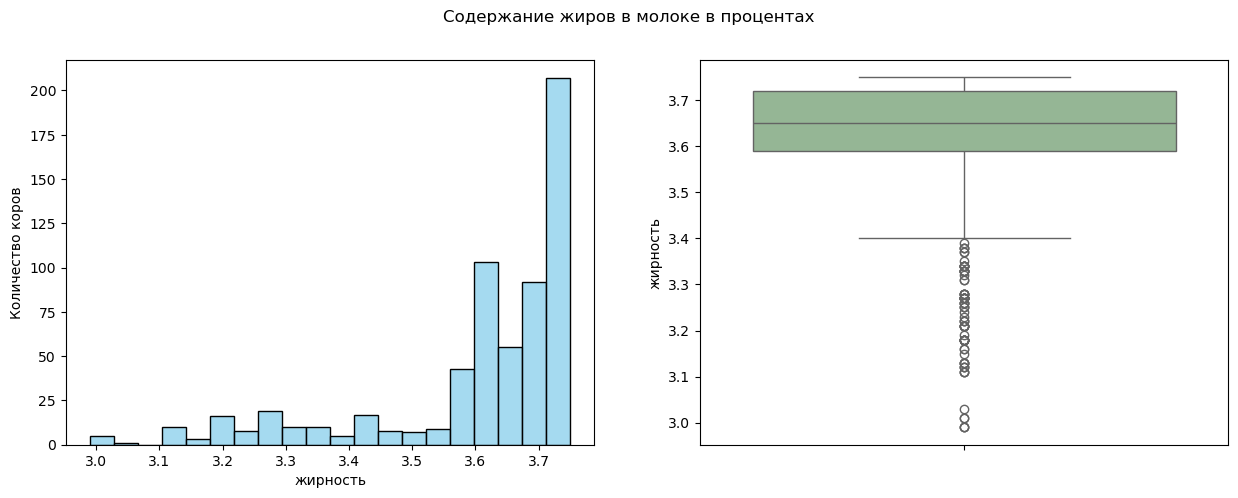

In [73]:
box_hist_plot(df_main, 'жирность', 'Содержание жиров в молоке в процентах')

In [74]:
print(f'Доля строк с выбросами признака "жирность": {(len(df_main.query("жирность < 3.4")) / len(df_main)):.1%}')

Доля строк с выбросами признака "жирность": 13.7%


**В столбце `жирность` молока наблюдается выбросы, но они составляют 13.7% от общего числа данных, поэтому удалить или заменить их будет нецелесообразно. Есть шанс повредить точность данных, поэтому оставим, как есть**

### Белок

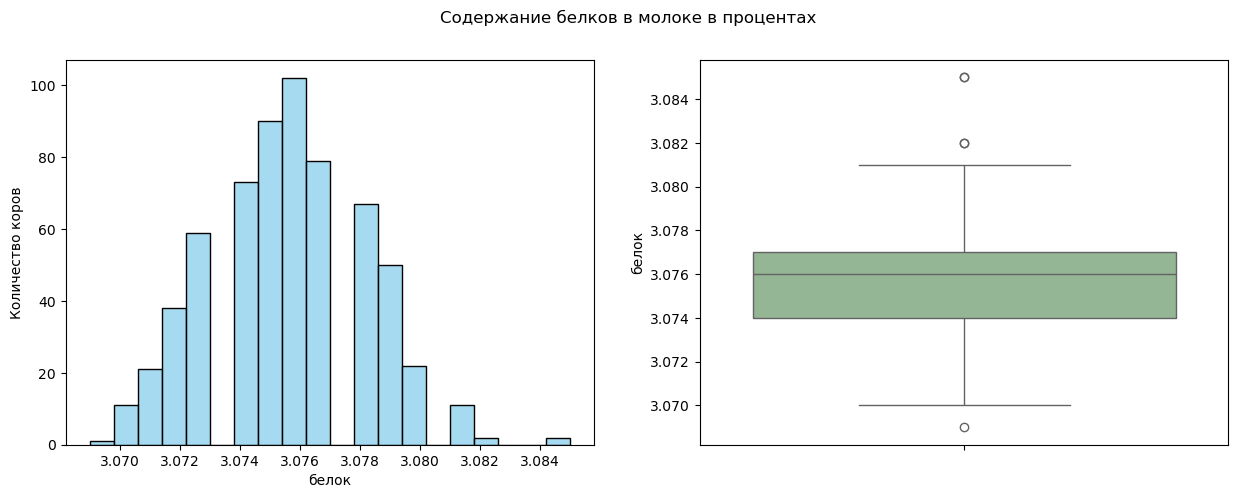

In [78]:
box_hist_plot(df_main, 'белок', 'Содержание белков в молоке в процентах')

In [79]:
df_main = df_main.query('3.070 < белок < 3.081')

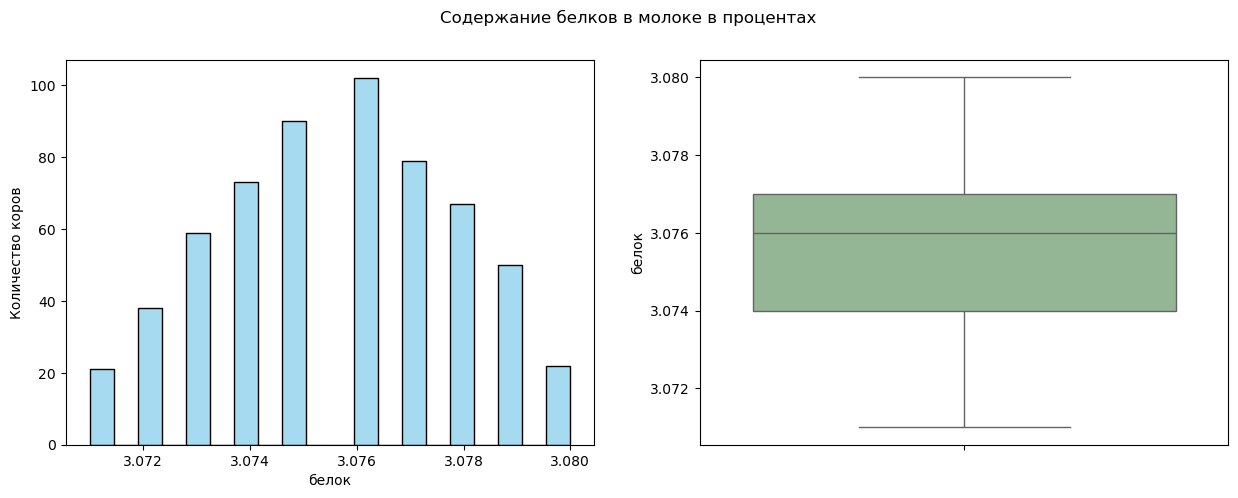

In [80]:
box_hist_plot(df_main, 'белок', 'Содержание белков в молоке в процентах')

**В признаке `белок` избавляемся от редких выбросов**

### Анализ качественных признаков

In [83]:
df_main.head()

,id,удой,эке,сырой_протеин,спо,порода,тип_пастбища,порода_папы_быка,жирность,белок,вкус_молока,возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет


In [84]:
# Функция для графика 
def bar_plot(df, column, title):
    sns.set_palette("Pastel1")
    ax = sns.countplot(data = df, x=column)
    ax.bar_label(ax.containers[0])
    plt.ylabel('Количество коров')
    plt.suptitle(title)
    plt.show()

### Порода

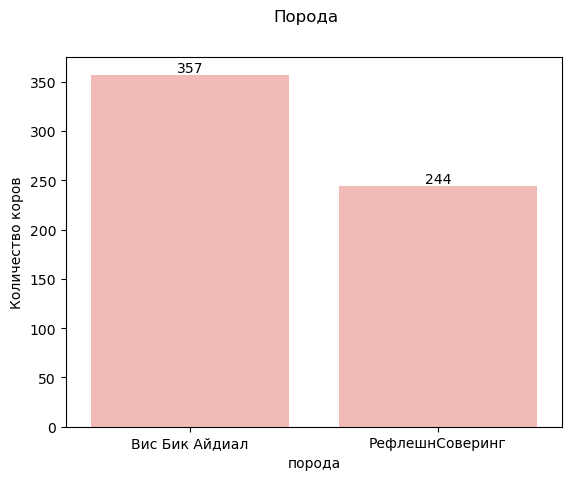

In [86]:
bar_plot(df_main, 'порода', 'Порода')

### Тип пастбища

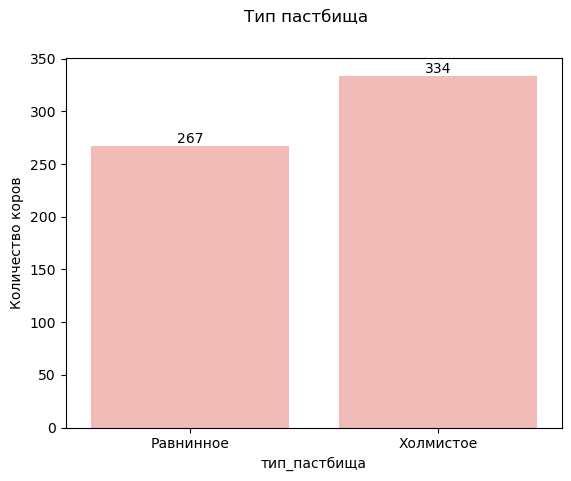

In [88]:
bar_plot(df_main, 'тип_пастбища', 'Тип пастбища')

### Порода папы быка

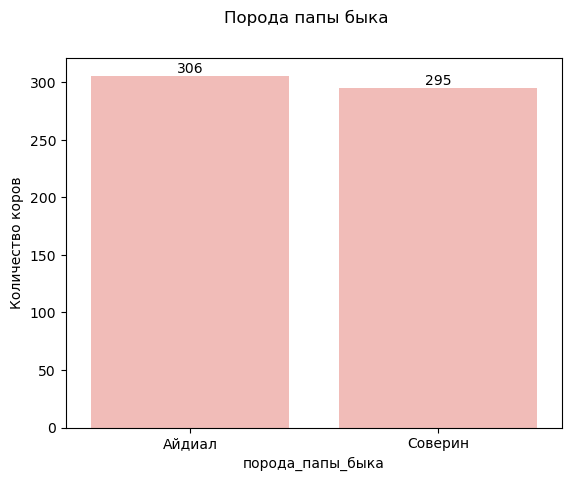

In [90]:
bar_plot(df_main, 'порода_папы_быка', 'Порода папы быка')

### Вкус молока

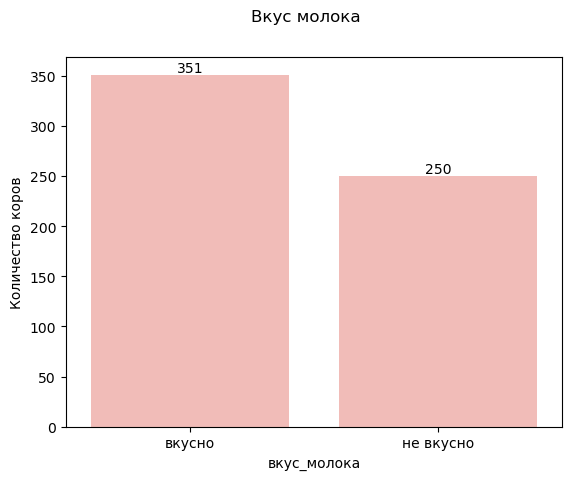

In [92]:
bar_plot(df_main, 'вкус_молока', 'Вкус молока')

### Возраст

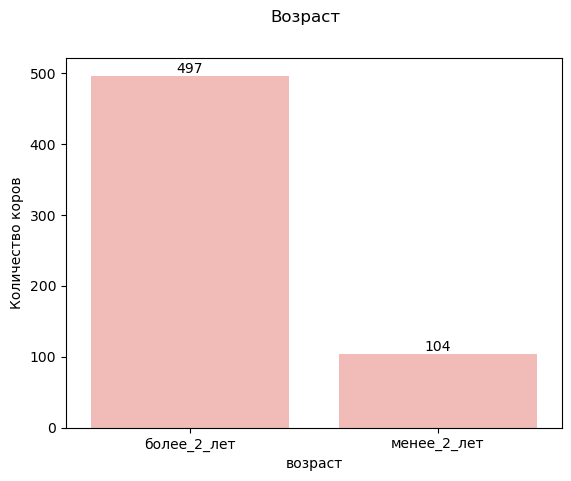

In [94]:
bar_plot(df_main, 'возраст', 'Возраст')

### Вывод по исследовательскому анализу
* Распределение количественных признаков близко к нормальному, кроме признаков `жирность`, `белок`, что связано с особенностями данных
* Избавились от выбросов в признаках `удой`, `белок`
* Категориальные признаки распределены достаточно равномерно, перевес чувствуется только в признаке `возраст`

## Корреляционный анализ

### Построим матрицу корреляции признаков

interval columns not set, guessing: ['id', 'удой', 'эке', 'сырой_протеин', 'спо', 'жирность', 'белок']


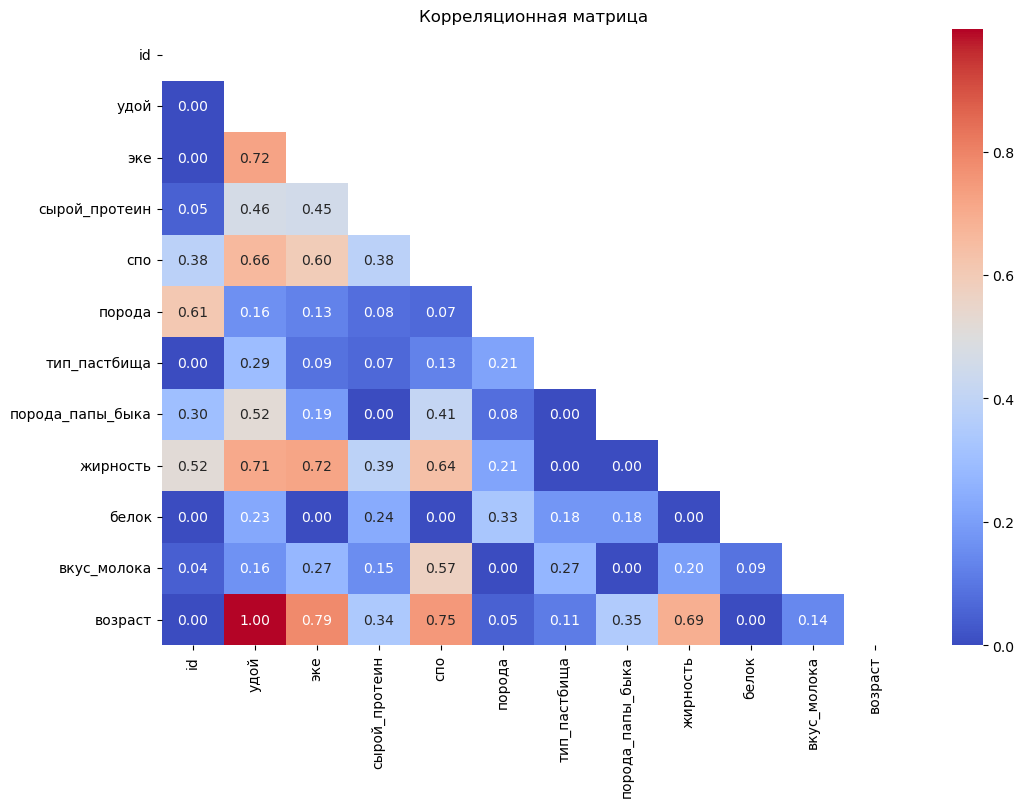

In [100]:
# Корреляционный анализ
phik_matrix = df_main.phik_matrix()

# Визуализация корреляционной матрицы 
mask = np.triu(np.ones_like(phik_matrix, dtype=bool))

plt.figure(figsize=(12, 8))
sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap="coolwarm", mask=mask)
plt.title("Корреляционная матрица")
plt.show()

### Построим диаграммы рассеяния зависимости признака удой от количественных на основе породы коров

In [103]:
num_col = ['эке', 'сырой_протеин', 'спо', 'жирность', 'белок']

Коэффициент корреляции Пирсона удоя и эке: 0.7686683988062918
Коэффициент корреляции Спирмана удоя и эке: 0.7673031942069197


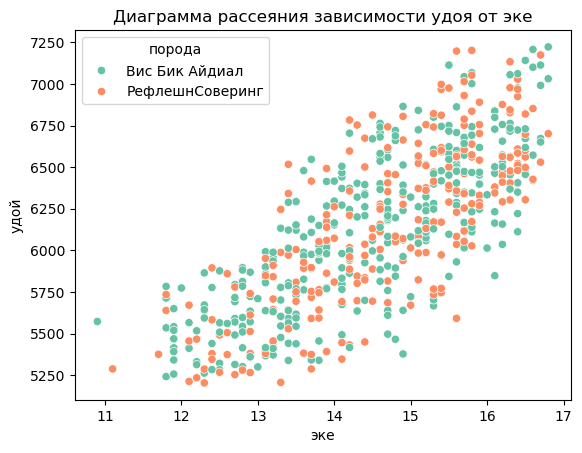

Коэффициент корреляции Пирсона удоя и сырой_протеин: 0.4397377469276221
Коэффициент корреляции Спирмана удоя и сырой_протеин: 0.42860421311924346


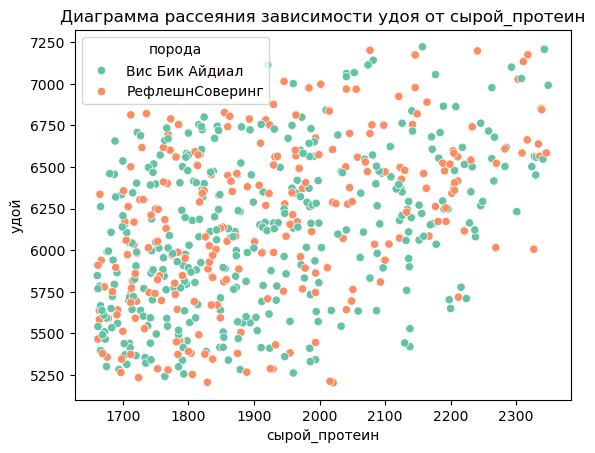

Коэффициент корреляции Пирсона удоя и спо: 0.8057262915014569
Коэффициент корреляции Спирмана удоя и спо: 0.7888303734616547


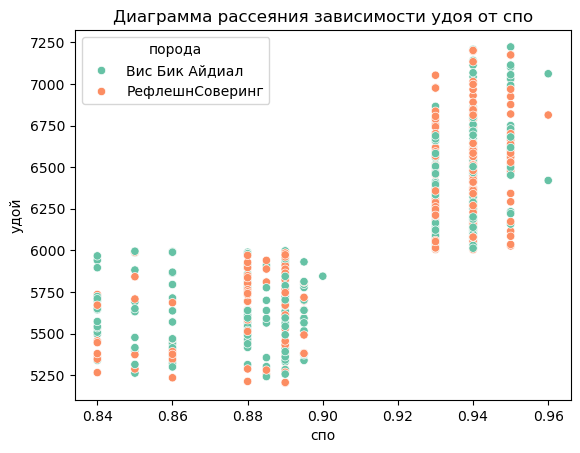

Коэффициент корреляции Пирсона удоя и жирность: 0.6045132596876123
Коэффициент корреляции Спирмана удоя и жирность: 0.6881409211946342


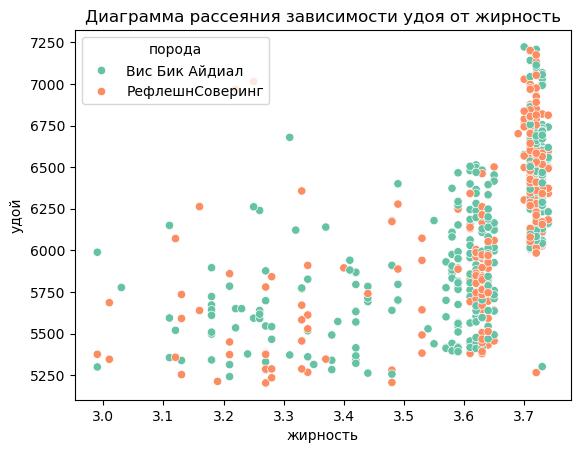

Коэффициент корреляции Пирсона удоя и белок: 0.004066926376744004
Коэффициент корреляции Спирмана удоя и белок: -0.006225199211042832


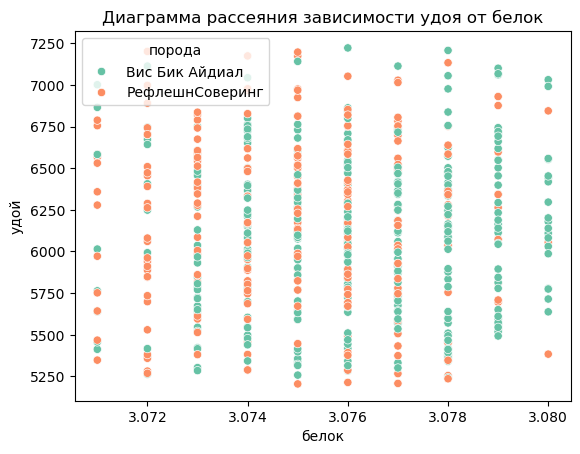

In [104]:
for column in num_col:
    sns.scatterplot(data=df_main, x=column, y='удой', hue='порода', palette='Set2')
    plt.title(f'Диаграмма рассеяния зависимости удоя от {column}')
    print(f'Коэффициент корреляции Пирсона удоя и {column}: {df_main['удой'].corr(df_main[column])}')
    print(f'Коэффициент корреляции Спирмана удоя и {column}: {df_main['удой'].corr(df_main[column], method='spearman')}')
    plt.show()

### Вывод по корреляционному анализу
Целевым признаком для нашей будущей модели является `удой`, на графиках видно следующие зависимости:
* `эке` имеет достаточно сильную линейную связь с целевым признаком. Коэффициент Пирсона = 0.77
* `сырой_протеин` обладает более слабой линейной зависимостью, но не такой, что можно пренебречь. Коэффициент Пирсона = 0.44
* `спо` не имеет линейной связи с целевым признаком, так как этот показатель принимает дискретные значения, т.е. больше походит на категориальный признак
* `жирность` обладает связью чуть выше средней. Коэффициент Пирсона = 0.60, это можно объяснить тем, что коровы в большинстве дают молоко с высоким показателем жирности, но учитывать этот признак для создания модели не следует, так как сама жирность молока на количество удоя никак не влияет
* `белок` линейная зависимость с целевым признаком отсутствует. Коэффициент Пирсона = 0.004
* Мультиколлинеарность между входными признаками не наблюдаетсяется.ется.

## Задача регресии

### Для первой модели избавимся от признаков `id`, `белок`, так как они не имеют влияния на наш целевой признак `удой`

In [111]:
df_ml1 = df_main.drop(['белок', 'id', 'жирность'], axis = 1)

In [112]:
# Функция для подготовки данных
def prepare_data(df, y, cat_col_names, num_col_names):
    RANDOM_STATE = 42

    X = df.drop(y, axis=1)
    y = df[y]

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        random_state=RANDOM_STATE
    )

    # подготовка признаков (масштабирование и кодирование)
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
    X_test_ohe = encoder.transform(X_test[cat_col_names])

    encoder_col_names = encoder.get_feature_names_out()

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[num_col_names])
    X_test_scaled = scaler.transform(X_test[num_col_names])

    X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
    X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

    X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

    X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
    X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

    return [X_train, X_test, y_train, y_test]

In [114]:
# выполняем подготовку данных функцией
cat_col_names = ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст']
num_col_names = ['эке', 'спо', 'сырой_протеин']
X_train, X_test, y_train, y_test = prepare_data(df_ml1, 'удой', cat_col_names, num_col_names)

In [116]:
model_1 = LinearRegression()
model_1.fit(X_train, y_train)
pred_1 = model_1.predict(X_test)
r2_1 = r2_score(y_test, pred_1)
mse_1 = mean_squared_error(y_test, pred_1)
rmse_1 = root_mean_squared_error(y_test, pred_1)
mae_1 = mean_absolute_error(y_test, pred_1)
print(f'R2_score первой модели: {r2_1}')
print(f'MSE_score первой модели: {mse_1}')
print(f'RMSE_score первой модели: {rmse_1}')
print(f'MAE_score первой модели: {mae_1}')

R2_score первой модели: 0.7896291380354956
MSE_score первой модели: 51035.669483527774
RMSE_score первой модели: 225.91075557292038
MAE_score первой модели: 177.50143971161742


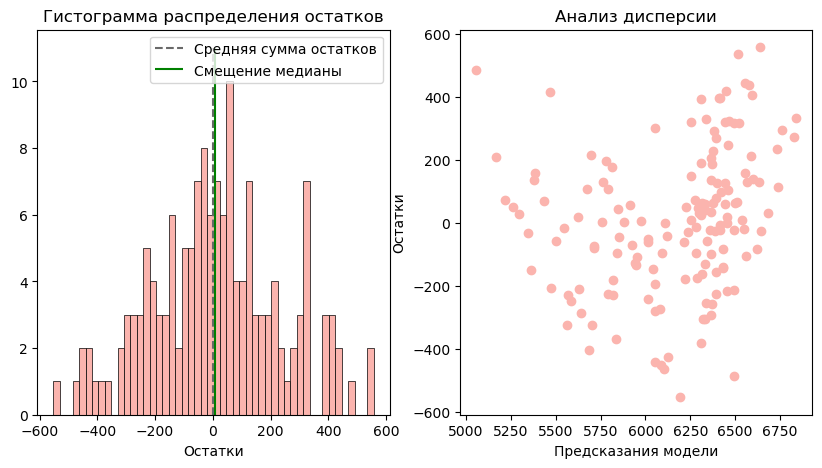

In [117]:
residuals_1 = y_test - pred_1

# постройте графики по количественным признакам — гистограмму частотности 
# распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals_1, bins = 50, edgecolor = 'black', linewidth=0.5)
zero = axes[0].vlines(x=0, colors='dimgrey', ymin=0, ymax=11, linestyles='--', label='Средняя сумма остатков')
median = axes[0].vlines(x=residuals_1.median(), colors='green', ymin=0, ymax=11, label='Смещение медианы')
axes[0].legend()
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(pred_1, residuals_1)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

**Анализ остатков первой модели:** 
* Модель имеет ассиметричное нормальное распредление, с пиком не в 0 количестве остатков, значит, модель чаще ошибается, чем показывает верное решение
* График дисперсии показывает, что остатки распределены неравномерно, модель чаще присвает слишком большое значение удоя

### Для второй модели преобразуем признак ЭКЕ, возведя его в квадрат, СПО переведем в категориальный признак

In [121]:
df_ml2 = df_main.copy(deep = True)
df_ml2 = df_ml2.drop(['белок', 'id', 'жирность'], axis = 1)

In [122]:
# Преобразуем признак ЭКЕ 
df_ml2['эке_в_квадрате'] = df_ml2['эке'] ** 2

# Преобразуем СПО в категориальный признак
df_ml2['спо_кат'] = df_ml2['спо'].apply(lambda x: 'более_0.91' if x > 0.91 else 'менее_0.91')
display(df_ml2['спо_кат'].value_counts())

спо_кат
более_0.91    359
менее_0.91    242
Name: count, dtype: int64

In [123]:
cat_col_names = ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст', 'спо_кат']
num_col_names = ['сырой_протеин','эке_в_квадрате']
X_train, X_test, y_train, y_test = prepare_data(df_ml2, 'удой', cat_col_names, num_col_names)

In [124]:
model_2 = LinearRegression()
model_2.fit(X_train, y_train)
pred_2 = model_2.predict(X_test)
r2_2 = r2_score(y_test, pred_2)
mse_2 = mean_squared_error(y_test, pred_2)
rmse_2 = root_mean_squared_error(y_test, pred_2)
mae_2 = mean_absolute_error(y_test, pred_2)
print(f'R2_score второй модели: {r2_2}')
print(f'MSE_score второй модели: {mse_2}')
print(f'RMSE_score второй модели: {rmse_2}')
print(f'MAE_score второй модели: {mae_2}')

R2_score второй модели: 0.8227311664476407
MSE_score второй модели: 43005.16485232259
RMSE_score второй модели: 207.37686672414208
MAE_score второй модели: 161.4599999384421


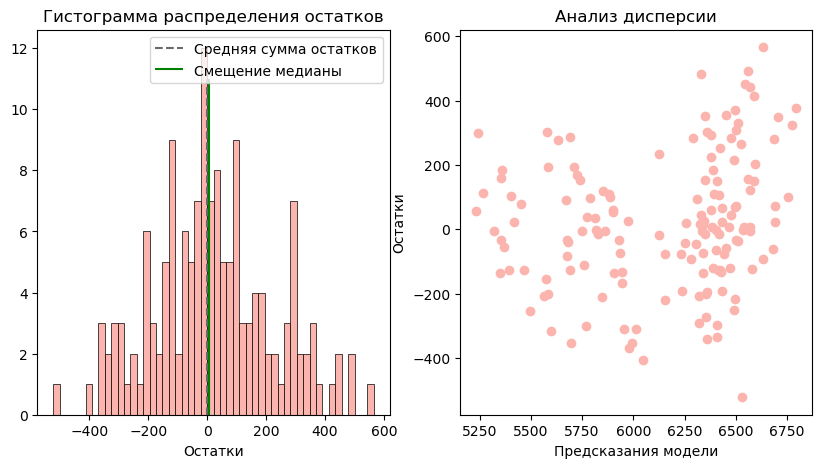

In [125]:
residuals_2 = y_test - pred_2

# постройте графики по количественным признакам — гистограмму частотности 
# распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals_2, bins = 50, edgecolor = 'black', linewidth=0.5)
zero = axes[0].vlines(x=0, colors='dimgrey', ymin=0, ymax=11, linestyles='--', label='Средняя сумма остатков')
median = axes[0].vlines(x=residuals_2.median(), colors='green', ymin=0, ymax=11, label='Смещение медианы')
axes[0].legend()
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(pred_2, residuals_2)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

**Анализ остатков первой модели:** 
* По сравнению с 1 моделью наибольшее значение остатков ближе к 0, что говорит о повышении качества предсказывания 
* График дисперсии также распределен более равномерно, но на больших значения все равно увеличивается

### Для третьей модели добавим информацию из датасета с df_dad

In [129]:
df_ml3 = df_main.merge(df_dad, on = 'id')

df_ml3 = df_ml3.drop(['белок', 'id','вкус_молока', 'жирность'], axis = 1)

# Преобразуем признак ЭКЕ 
df_ml3['эке_в_квадрате'] = df_ml3['эке'] ** 2

# Преобразуем СПО в категориальный признак
df_ml3['спо_кат'] = df_ml3['спо'].apply(lambda x: 'более_0.91' if x > 0.91 else 'менее_0.91')

In [130]:
df_ml3

,удой,эке,сырой_протеин,спо,порода,тип_пастбища,порода_папы_быка,возраст,имя_папы,эке_в_квадрате,спо_кат
0,5863,14.200000,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,более_2_лет,Буйный,201.639999,менее_0.91
1,5529,12.800000,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,менее_2_лет,Соловчик,163.840012,менее_0.91
2,5810,14.000000,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,более_2_лет,Барин,196.000000,менее_0.91
3,5895,12.400000,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,более_2_лет,Буйный,153.759995,менее_0.91
4,5302,12.800000,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,менее_2_лет,Барин,163.840012,менее_0.91
...,...,...,...,...,...,...,...,...,...,...,...
596,6812,15.400000,1964,0.940,РефлешнСоверинг,Равнинное,Айдиал,более_2_лет,Буйный,237.159988,более_0.91
597,5513,12.900000,1700,0.880,РефлешнСоверинг,Равнинное,Соверин,менее_2_лет,Барин,166.409988,менее_0.91
598,5970,14.400000,1837,0.880,РефлешнСоверинг,Холмистое,Соверин,более_2_лет,Барин,207.359985,менее_0.91
599,5746,13.800000,1994,0.890,РефлешнСоверинг,Равнинное,Соверин,более_2_лет,Барин,190.440002,менее_0.91


In [131]:
cat_col_names = ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст', 'имя_папы', 'спо_кат']
num_col_names = ['сырой_протеин','эке_в_квадрате']
X_train, X_test, y_train, y_test = prepare_data(df_ml3, 'удой', cat_col_names, num_col_names)

In [132]:
X_train_full = pd.concat([X_train, X_test], ignore_index=True)
y_train_full = pd.concat([y_train, y_test], ignore_index=True)

In [133]:
model_3 = LinearRegression()
model_3.fit(X_train, y_train)
pred_3 = model_3.predict(X_test)
r2_3 = r2_score(y_test, pred_3)
mse_3 = mean_squared_error(y_test, pred_3)
rmse_3 = root_mean_squared_error(y_test, pred_3)
mae_3 = mean_absolute_error(y_test, pred_3)
print(f'R2_score третьей модели: {r2_3}')
print(f'MSE_score третьей модели: {mse_3}')
print(f'RMSE_score третьей модели: {rmse_3}')
print(f'MAE_score третьей модели: {mae_3}')

R2_score третьей модели: 0.8439009473893411
MSE_score третьей модели: 37869.40634902945
RMSE_score третьей модели: 194.60063296153342
MAE_score третьей модели: 149.6005928173078


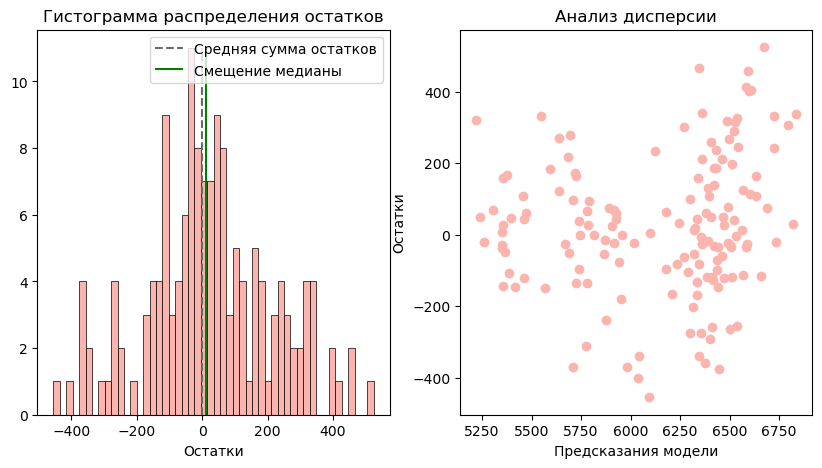

In [134]:
residuals_3 = y_test - pred_3

# постройте графики по количественным признакам — гистограмму частотности 
# распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals_3, bins = 50, edgecolor = 'black', linewidth=0.5)
zero = axes[0].vlines(x=0, colors='dimgrey', ymin=0, ymax=11, linestyles='--', label='Средняя сумма остатков')
median = axes[0].vlines(x=residuals_3.median(), colors='green', ymin=0, ymax=11, label='Смещение медианы')
axes[0].legend()
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(pred_3, residuals_3)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

**Анализ остатков первой модели:** 
* Модель имеет ассиметричное нормальное распределение со смещением вправо, значит, модель чаще завышает полученное значение
* График дисперсии показывает, что остатки получили самое равномерное распределение среди трех моделей

In [136]:
scores_r2 = {'первой': r2_1, 'второй': r2_2, 'третьей': r2_3}
for model, r in scores_r2.items():
    print(f'R2_score для {model}: {r}')

R2_score для первой: 0.7896291380354956
R2_score для второй: 0.8227311664476407
R2_score для третьей: 0.8439009473893411


In [137]:
residuals = {'первой': residuals_1, 'второй': residuals_2, 'третьей': residuals_3}
for model, residual in residuals.items():
    print(f'Среднее значение остатков {model} модели: {residual.mean()}')

Среднее значение остатков первой модели: 9.692043330754998
Среднее значение остатков второй модели: 19.459460480226024
Среднее значение остатков третьей модели: 24.73638871628902


In [138]:
mse_compared = {'первой': mse_1, 'второй': mse_2, 'третьей': mse_3}
for model, mse in mse_compared.items():
    print(f'MSE {model} модели: {mse}')

MSE первой модели: 51035.669483527774
MSE второй модели: 43005.16485232259
MSE третьей модели: 37869.40634902945


In [139]:
rmse_compared = {'первой': rmse_1, 'второй': rmse_2, 'третьей': rmse_3}
for model, rmse in rmse_compared.items():
    print(f'RMSE {model} модели: {rmse}')

RMSE первой модели: 225.91075557292038
RMSE второй модели: 207.37686672414208
RMSE третьей модели: 194.60063296153342


In [140]:
mae_compared = {'первой': mae_1, 'второй': mae_2, 'третьей': mae_3}
for model, mae in mae_compared.items():
    print(f'MAE {model} модели: {mae}')

MAE первой модели: 177.50143971161742
MAE второй модели: 161.4599999384421
MAE третьей модели: 149.6005928173078


In [141]:
interval = st.norm.interval(confidence= 0.95 , loc=np.mean(pred_3), scale=st.sem(pred_3))

print(f'Доверительный интервал модели: {interval[0].round(2)} - {interval[1].round(2)}')

Доверительный интервал модели: 6076.69 - 6213.53


### Вывод по моделям линейной регрессии:
* Самый высокий **R2_score: 0.8439009473893411** показывает третья модель
* Так же третья модель имеет лучшие показатели **MSE: 37869.40634902945, RMSE: 194.60063296153342, MAE: 149.6005928173078**
* Первая модель выигрывает только в показателе **Среднее значение остатков: 10.352425311026176**\
**Лучшей моделью оказалась третья, ее доверительный интервал 6076.69 - 6213.53**

### Прогноз удоя

In [146]:
df_buy['эке_в_квадрате'] = (((df_main['эке'].mean() * 1.05))**2).round(2)
df_buy['сырой_протеин'] = (df_main['сырой_протеин'].mean() * 1.05).round(2)
df_buy['спо'] = df_main['спо'].mean() * 1.05
df_buy['спо_кат'] = df_buy['спо'].apply(lambda x: 'более_0.91' if x > 0.91 else 'менее_0.91')

In [147]:
cat_col_names = ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст', 'имя_папы', 'спо_кат']
num_col_names = ['сырой_протеин', 'эке_в_квадрате']

encoder = OneHotEncoder(drop='first', sparse_output=False)
encoder.fit(df_ml3[cat_col_names])
data_ohe = encoder.transform(df_buy[cat_col_names])
encoder_col_names = encoder.get_feature_names_out()
data_ohe = pd.DataFrame(data_ohe, columns=encoder_col_names)

scaler = StandardScaler()
scaler.fit(df_ml3[num_col_names])
data_scaled = scaler.transform(df_buy[num_col_names])
data_scaled = pd.DataFrame(data_scaled, columns=num_col_names)

final_data = pd.concat([data_ohe, data_scaled], axis=1)
final_predictions = model_3.predict(final_data)
for i in range(len(df_buy)):
  df_buy.loc[i,'удой'] = final_predictions[i]

In [149]:
df_buy

,порода,тип_пастбища,порода_папы_быка,имя_папы,жирность,белок,возраст,эке_в_квадрате,сырой_протеин,спо,спо_кат,удой
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,233.06,2019.55,0.959151,более_0.91,6590.531602
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,233.06,2019.55,0.959151,более_0.91,6307.163710
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,233.06,2019.55,0.959151,более_0.91,6281.590597
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,233.06,2019.55,0.959151,более_0.91,6571.473815
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,233.06,2019.55,0.959151,более_0.91,6519.921447
5,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,233.06,2019.55,0.959151,более_0.91,6375.380790
6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,233.06,2019.55,0.959151,более_0.91,6590.531602
7,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,233.06,2019.55,0.959151,более_0.91,6523.100474
8,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,233.06,2019.55,0.959151,более_0.91,6281.590597
9,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,233.06,2019.55,0.959151,более_0.91,6355.537051


### Вывод для задачи линейной регрессии:
* Лучшая модель - третья
* * MSE: 37869.40634902945
  * RMSE: 194.60063296153342
  * MAE: 149.6005928173078
  * R2_score: 0.8439009473893411
* На основе третьей модели предсказали удой коров из датасета для покупки `df_buy`, все коровы дают более 6000 кг удоя в год

## Задача классификации

In [153]:
df_lr = df_main.copy()

### Преобразуем нужные признаки

In [155]:
df_lr['вкус_молока'] = df_lr['вкус_молока'].apply(lambda x: 1 if x == 'вкусно' else 0)

In [156]:
# Преобразуем признак ЭКЕ 
df_lr['эке_в_квадрате'] = df_lr['эке'] ** 2

# Преобразуем СПО в категориальный признак
df_lr['спо_кат'] = df_lr['спо'].apply(lambda x: 'более_0.91' if x > 0.91 else 'менее_0.91')

In [157]:
df_lr

,id,удой,эке,сырой_протеин,спо,порода,тип_пастбища,порода_папы_быка,жирность,белок,вкус_молока,возраст,эке_в_квадрате,спо_кат
0,1,5863,14.200000,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,1,более_2_лет,201.639999,менее_0.91
1,2,5529,12.800000,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,1,менее_2_лет,163.840012,менее_0.91
2,3,5810,14.000000,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,0,более_2_лет,196.000000,менее_0.91
3,4,5895,12.400000,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,0,более_2_лет,153.759995,менее_0.91
4,5,5302,12.800000,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,1,менее_2_лет,163.840012,менее_0.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
624,625,6812,15.400000,1964,0.940,РефлешнСоверинг,Равнинное,Айдиал,3.74,3.075,0,более_2_лет,237.159988,более_0.91
625,626,5513,12.900000,1700,0.880,РефлешнСоверинг,Равнинное,Соверин,3.64,3.073,1,менее_2_лет,166.409988,менее_0.91
626,627,5970,14.400000,1837,0.880,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,0,более_2_лет,207.359985,менее_0.91
627,628,5746,13.800000,1994,0.890,РефлешнСоверинг,Равнинное,Соверин,3.64,3.077,1,более_2_лет,190.440002,менее_0.91


In [158]:
cat_col_names = ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст', 'спо_кат']
num_col_names = ['сырой_протеин','эке_в_квадрате', 'удой', 'жирность', 'белок']
X_train, X_test, y_train, y_test = prepare_data(df_lr, 'вкус_молока', cat_col_names, num_col_names)

In [159]:
clf = LogisticRegression()

# обучаем модель на данных
clf = clf.fit(X_train, y_train)

# получаем прогнозные метки классов
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
recall =  recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print(f'Accuracy: {acc}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')

Accuracy: 0.6225165562913907
Recall: 0.7954545454545454
Precision: 0.6422018348623854


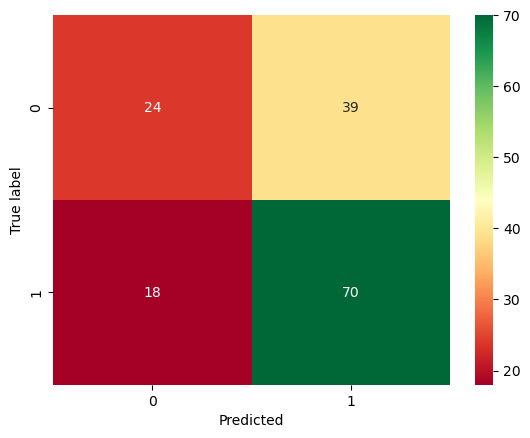

In [160]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn')
plt.ylabel('True label')
plt.xlabel('Predicted');

* Метрика precision имеет значение - 0.6225165562913907
* Имеем 39 ошибок первого рода, значит, модель дает ложноположительные предсказания, называя не вкусное молоко вкусным \
**Для нашей задачи ложноположительная ошибка имеет наибольшее значение, так как заказчику важно отобрать коров с вкусным молоком. Чтобы исправить ситуацию с выдачей ложноположительных ошибок, необходимо максимизировать метрику Precision**

### Проведем подбор порога класса, чтобы минимизировать ошибки первого рода

In [248]:
y_proba = clf.predict_proba(X_test)[:, 1]

proba_data = pd.DataFrame(zip(y_test, y_proba),
                          columns=['y_test', 'y_proba']).sort_values(by='y_proba', ascending=False)

proba_data.head()

,y_test,y_proba
87,1,0.888480
118,1,0.887787
2,1,0.874539
19,1,0.859851
97,1,0.853394


In [250]:
thresholds = [round(i,2) for i in np.linspace(0.1,0.9,num = 1000,endpoint=False)]

In [252]:
columns = []

for i in thresholds:
    columns.append('y_pred_'+str(i))
    proba_data['y_pred_'+str(i)] = proba_data['y_proba'].apply(lambda x: 1 if x>= i else 0)
proba_data.head()

,y_test,y_proba,y_pred_0.1,y_pred_0.11,y_pred_0.12,y_pred_0.13,y_pred_0.14,y_pred_0.15,y_pred_0.16,y_pred_0.17,...,y_pred_0.81,y_pred_0.82,y_pred_0.83,y_pred_0.84,y_pred_0.85,y_pred_0.86,y_pred_0.87,y_pred_0.88,y_pred_0.89,y_pred_0.9
87,1,0.888480,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
118,1,0.887787,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
2,1,0.874539,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0,0,0
19,1,0.859851,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,0,0,0,0
97,1,0.853394,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,0,0,0,0


In [254]:
best_threshold = None

for i in sorted(set(thresholds)):
    y_pred = proba_data['y_pred_' + str(i)]
    cm = confusion_matrix(y_test, y_pred)

    FP = cm[0][1]
    TP = cm[1][1]

    if FP <= 4 and TP > 3:
        print(f'Подходящий порог найден: {i}')
        print(f'Confusion Matrix:\n{cm}')
        print(f'Precision = {round(precision_score(y_test, y_pred, zero_division=0), 2)}')
        best_threshold = i
        break

if best_threshold is None:
    print("Не найден порог, удовлетворяющий условиям FP ≤ 4 и TP > 4")

Подходящий порог найден: 0.82
Confusion Matrix:
[[59  4]
 [84  4]]
Precision = 0.5


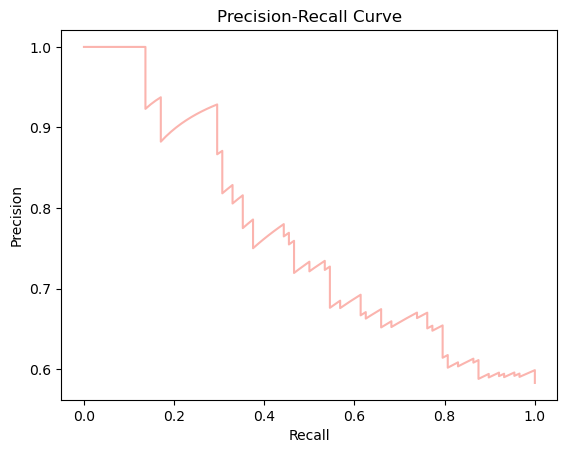

In [256]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

fig, ax = plt.subplots()
ax.plot(recall, precision)

ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

plt.show()

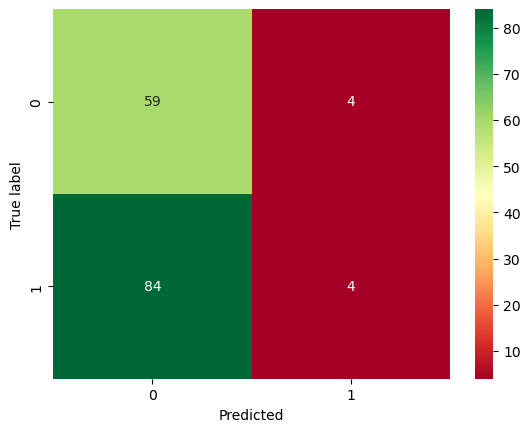

In [258]:
cm = confusion_matrix(y_test, proba_data['y_pred_'+str(i)])
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn')
plt.ylabel('True label')
plt.xlabel('Predicted');

**Матрица ошибок с полученным порогом показывает наглядно, что ложноположительные ошибки действительно были минимизированы**

### Предскажем вкус молока с подобранным порогом 

In [260]:
if 'вкус_молока' not in df_buy.columns:
    df_buy['вкус_молока'] = 0

In [264]:
X_train = df_lr
X_test = df_buy

target = 'вкус_молока'
cat_col_names = ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст']
num_col_names = ['эке_в_квадрате', 'сырой_протеин', 'спо', 'жирность' , 'белок']

X = X_train.drop(target, axis=1)
y = X_train[target]

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_ohe = encoder.fit_transform(X[cat_col_names])

encoder_col_names = encoder.get_feature_names_out()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[num_col_names])

X_ohe = pd.DataFrame(X_ohe, columns=encoder_col_names)

X_scaled = pd.DataFrame(X_scaled, columns=num_col_names)

X = pd.concat([X_ohe, X_scaled], axis=1)
                  
clf = LogisticRegression()
clf = clf.fit(X, y)

X = X_test.drop(target, axis=1)
y = X_test[target]

X_ohe = encoder.transform(X[cat_col_names])

encoder_col_names = encoder.get_feature_names_out()

X_scaled = scaler.transform(X[num_col_names])

X_ohe = pd.DataFrame(X_ohe, columns=encoder_col_names)
X_scaled = pd.DataFrame(X_scaled, columns=num_col_names)

X_cow = pd.concat([X_ohe, X_scaled], axis=1)   

y_pred = clf.predict_proba(X_cow)[:,1] 

df_buy['y_pred'] = y_pred

df_buy['вкус_молока'] = df_buy['y_pred'].apply(lambda x: 'вкусно' if x >  best_threshold else 'не вкусно')      

df_buy = df_buy.sort_values(by = ['y_pred'], ascending = False)
df_buy = df_buy.drop(columns='y_pred') 

display(df_buy)

,порода,тип_пастбища,порода_папы_быка,имя_папы,жирность,белок,возраст,эке_в_квадрате,сырой_протеин,спо,спо_кат,удой,вкус_молока
9,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,233.06,2019.55,0.959151,более_0.91,6355.537051,вкусно
13,Вис Бик Айдиал,Холмистое,Соверин,Барин,3.42,3.075,менее_2_лет,233.06,2019.55,0.959151,более_0.91,6092.626555,не вкусно
16,Вис Бик Айдиал,Холмистое,Соверин,Соловчик,3.73,3.079,более_2_лет,233.06,2019.55,0.959151,более_0.91,6346.056143,не вкусно
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,233.06,2019.55,0.959151,более_0.91,6590.531602,не вкусно
6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,233.06,2019.55,0.959151,более_0.91,6590.531602,не вкусно
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,233.06,2019.55,0.959151,более_0.91,6307.163710,не вкусно
7,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,233.06,2019.55,0.959151,более_0.91,6523.100474,не вкусно
15,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.065,более_2_лет,233.06,2019.55,0.959151,более_0.91,6571.473815,не вкусно
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,233.06,2019.55,0.959151,более_0.91,6281.590597,не вкусно
8,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,233.06,2019.55,0.959151,более_0.91,6281.590597,не вкусно


**В итоге на рассмотренном датасете только одна корова дает вкусное молоко**

## Общий вывод

1. Предобработка данных

* Обнаружили и избавились от явных и неявных дубликатов
* Определили, что стоит изменить названия столбцов и привести их к единому виду
* Не выявили пропущенных значений
* Изменили типы данных, где это было необходимо

2. Исследовательский анализ данных

* Выявили, что почти все признаки распределены нормально и не требуют особых корректировок выбросов
* Убрали аномальное значение признака `удой` == 45616
* В признаке `белок` избавились от выбросов
* В категориальных данных не вносили изменений, так как их распределение в порядке

3. Корреляционный анализ данных

Целевым признаком для нашей будущей модели является `удой`, на графиках видно следующие зависимости:
* `эке` имеет достаточно сильную линейную связь с целевым признаком. Коэффициент Пирсона = 0.77
* `сырой_протеин` обладает более слабой связью, но не такой, что можно пренебречь. Коэффициент Пирсона = 0.44
* `спо` имеет сильную связь с целевым признаком, но по графику видно, что она вероятно не является линейной. Коэффициент Пирсона = 0.80
* `жирность` обладает связью чуть выше средней. Коэффициент Пирсона = 0.60
* `белок` имеет самую слабую связь, линейная зависимость с целевым признаком отсутствует. Коэффициент Пирсона = 0.004

4. Решение задачи регресии 

* Обучили 3 модели линейной регрессии

Лучшая полученная модель:
* MSE: 37869.40634902945
* RMSE: 194.60063296153342
* MAE: 149.6005928173078
* R2_score: 0.8439009473893411
На основе третьей модели предсказали удой коров из датасета для покупки `df_buy`, все коровы дают более 6000 кг удоя в год

6. Решение задачи классификации 

* Обучили модель логистической регрессии
* Проанализировали модель и минимизировали количество критических ошибок первого рода, подобрав новый порог для вероятности предсказаний

7. Общие рекомендации
* Наилучший выбор оптимальных коров для покупки будет доступен после увеличения количества вариантов коров для продажи, то есть заказчику стоит рассмотреть большее количество кандидатов
* Самым важным фактором при покупке коровы с вкусным молоком будет минимизация ложноположительных ошибок, так как покупка коров с не вкусным молоком грозит бизнесу заказчика 